___
## Attempt to convert osm to geojson failed - how to download maps dynamically?

In [1]:
# min_long = 37.52408
# min_lat = 55.70015
# max_long = 37.54093
# max_lat = 55.70514
# addr = "\"https://api.openstreetmap.org/api/0.6/map?bbox=" \
#     + str(min_long)  + ',' + str(min_lat) + ',' + str(max_long) + ',' + str(max_lat) + '"'

# !curl -o test_map.osm $addr

# import shutil
# import sys
# !mv test_map.osm data
# # with open('data/test_map.osm', encoding='utf-8') as file:
# #     shutil.copyfileobj(file, sys.stdout)

In [2]:
# import codecs
# import osm2geojson
# import geopandas

# with codecs.open('data/test_map.osm', 'r', encoding='utf-8') as data:
#     xml = data.read()

# geojson = osm2geojson.xml2geojson(xml, filter_used_refs=False, log_level='INFO')

# gp.read_file(geojson)

___
## Parsing predownloaded pbf maps

In [34]:
import geopandas
from pyrosm import OSM

[Parts of the world](http://download.geofabrik.de/)  
[Cities](https://download.bbbike.org/osm/bbbike/)  
[Choose borders](https://extract.bbbike.org/)  
[OSM API](https://wiki.openstreetmap.org/wiki/Overpass_API/Overpass_QL) - possible solution

<AxesSubplot:>

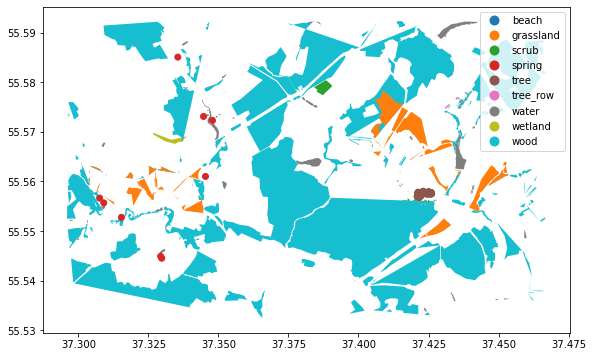

In [35]:
osm = OSM("data/valuevo.osm.pbf") #possible use of boundary_box parameter and download whole world
# custom_filter = {"natural" : True}
# natural = osm.get_data_by_custom_criteria(custom_filter = custom_filter, keep_nodes = True)
natural = osm.get_natural(extra_attributes=['nodes'])
natural.plot(column='natural', legend=True, figsize=(10,6))
# print("\nAdditional attributes in the 'tags': \n", natural.tags.unique())

In [36]:
natural.tail(2)

,id,version,timestamp,changeset,lat,lon,tags,natural,geometry,osm_type,water,wetland
295,507346879,-1,0,0.0,NaN,NaN,"{""type"":""multipolygon""}",wood,"MULTIPOLYGON (((37.39658 55.56861, 37.40027 55...",relation,None,NaN
296,1422051155,-1,0,0.0,NaN,NaN,"{""type"":""multipolygon""}",wood,"MULTIPOLYGON (((37.37494 55.57638, 37.36149 55...",relation,None,NaN


In [37]:
natural.geometry.type.unique()

array(['Point', 'Polygon', 'LineString', 'MultiLineString',
       'MultiPolygon'], dtype=object)

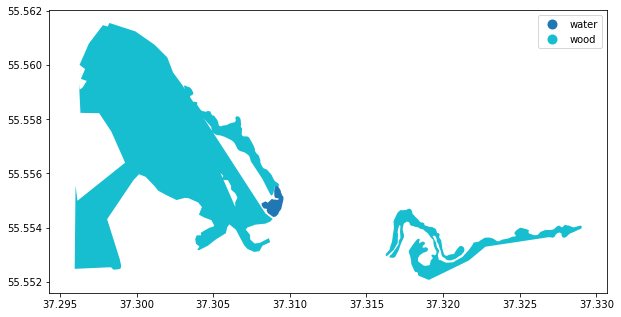

In [51]:
polygons = natural.loc[:, ['natural', 'geometry']].loc[natural.geometry.type == 'Polygon'].tail(4)
polygons.plot(column='natural', legend=True, figsize=(10,6));

___
## Building a convex hull

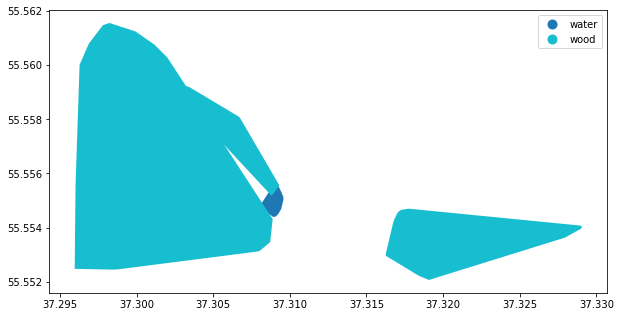

In [52]:
polygons.geometry = polygons.geometry.convex_hull #check for efficiency and rewrite if needed
polygons.plot(column='natural', legend=True, figsize=(10,6));

___
## Find optimal pair

In [40]:
import numpy as np
import math

def vec(a, b):
    return np.array(b) - np.array(a)

def mod(v):
    return (v[0]**2 + v[1]**2)**0.5

def point_in_angle(p, a, b, c):
    delta = 0.00000001
    return math.fabs(math.acos(np.dot(vec(b,a), vec(b,c))/(mod(vec(b, a)) * mod(vec(b,c)))) - \
        math.acos(np.dot(vec(b,a), vec(b,p))/(mod(vec(b,a)) * mod(vec(b,p)))) - \
        math.acos(np.dot(vec(b,p), vec(b,c))/(mod(vec(b,p)) * mod(vec(b,c))))) < delta

def find_pair(point, left_border, right_border, coord):
    n = len(coord) - 1
    # optimize list work
    b = [1 for i in range(n)]
    count = 0
    for i in range(n):
        if not point_in_angle(point, coord[(i-1)%n], coord[i%n], coord[(i+1)%n]) and \
                not point_in_angle(coord[i%n], left_border, point, right_border):
            b[i] = 0
            count += 1
    if count == 0:
        return 1
    if count == n:
        print("Point inside a polygon")
        return 0
    if b[0] == 1:
        start = b.index(0, 1)
        if b[n-1] == 0:
            end = n-1
        else:
            end = b.index(1, start + 1)
            end -= 1
    if b[0] == 0:
        start = b.index(1, 1)
        start -= 1
        if b[n-1] == 1:
            end = n
        else:
            end = b.index(0, start + 1)
    return (start, end)

___
## Build a graph

In [55]:
from shapely.geometry import Polygon, mapping
import matplotlib.pyplot as plt
import mplleaflet
import networkx as nx

In [60]:
def build_graph(polygons):
    poly_number = polygons.shape[0]
    fig = plt.figure()
    G = nx.MultiGraph(crs='EPSG:4326')
    max_poly_len = 1000000 # for graph indexing

    for i in range(poly_number):

        x_arr, y_arr = (polygons.iloc[i,1]).exterior.coords.xy
        plt.plot(x_arr, y_arr);

        coords_1 = mapping(polygons.iloc[i,1])['coordinates'][0]
        for j in range(poly_number):
            if j == i:
                continue

            coords_2 = mapping(polygons.iloc[j,1])['coordinates'][0]
            n = len(coords_2) - 1
            for k in range(n):
                point = coords_2[k]
                left_border = coords_2[(k-1)%n]
                right_border = coords_2[(k+1)%n]
                pair = find_pair(point, left_border, right_border, coords_1)
                if pair == 1:
                    continue

                G.add_node(j * max_poly_len + k, x=point[0], y=point[1])
                x1 = coords_1[pair[0]][0]
                x2 = coords_1[pair[1]][0]
                y1 = coords_1[pair[0]][1]
                y2 = coords_1[pair[1]][1]
                G.add_node(i * max_poly_len + pair[0], x = x1, y = y1)
                G.add_node(i * max_poly_len + pair[1], x = x2, y = y2)
                G.add_edge(i * max_poly_len + pair[0], j * max_poly_len + k)
                G.add_edge(i * max_poly_len + pair[1], j * max_poly_len + k)

                plt.plot([point[0], x1], [point[1], y1]);
                plt.plot([point[0], x2], [point[1], y2]);

    # mplleaflet.display(fig=fig)
    return G, fig

In [61]:
G, fig = build_graph(polygons)
mplleaflet.display(fig=fig)

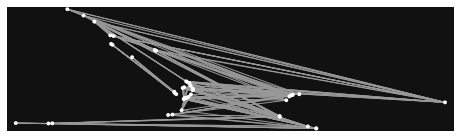

In [62]:
import osmnx as ox
ox.plot_graph(G);

___
Problems:
- Too many nodes: pollible ramer-douglas-peucker algorithm
- Uncovered crosses
- Inside polygon no nodes and edges